# __YÜKSEK DAYANIMLI BETON TAHMİNİ__

## _KEŞİFSEL VERİ ANALİZİ & LİNEER REGRESYONU_

### 1. Giriş

Beton kalitesini belirlemek için, beton dayanım testlerine tabi tutulur. Bu testler, değişen miktarla beraber en iyi sonuç üretilmeye çalışılmaktadır. Beton dayanımından en iyi sonucu almak için bileşen miktarlarının doğru ayarlanması gerekmektedir. Beton dayanımı, bileşenleri ile lineer olmayan bir ilişki bulunmaktadır.
Dayanımı artırmak için bileşenler arasına yer yer katkı malzemeleride eklenebilir.

_Amacımız, farklı beton numunelerinden alınan karışımları inceleyeerek en ideal beton formülünü bulmaktır._

Veriler UCI Machine Learning Repository'den alınmıştır. Kullandığımız set, 1030 satır ve 9 kolon veriden oluşmaktadır.

>   ##### Bileşenler
>   - Çimento (kg/m3)
>   - Yüksek Fırınlı Cüruf (kg/m3)
>   - Uçucu Kül (kg/m3)
>   - Su (kg/m3)
>   - Akışkanlaştırıcı (kg/m3)
>   - İri Agrega (kg/m3)
>   - İnce Agrega (kg/m3)
>   - Yaş (gün)
>   - Beton Basınç Dayanımı (MPa)

### 2. Veri Derlenmesi

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
pd.set_option("display.float_format", "{:.3f}".format)
sns.set()

In [2]:
df = pd.read_excel('Concrete_Data.xls')

In [3]:
df.columns = ['Cement', 'Slag', 'FlyAsh', 'Water' , 'SPs', 'CoarseAgg', 'FineAgg', 'Day', 'Strength']  #sutunlar adlandırıldı
df['WC'] = df.Water / df.Cement  #yeni sütun eklendi
df = df[['Cement', 'Slag', 'FlyAsh', 'Water' , 'SPs' , 'CoarseAgg', 'FineAgg', 'WC', 'Day', 'Strength']]  #sütunlar sıralandı

In [4]:
df.head(3)

,Cement,Slag,FlyAsh,Water,SPs,CoarseAgg,FineAgg,WC,Day,Strength
0,540.000,0.000,0.000,162.000,2.500,1040.000,676.000,0.300,28,79.986
1,540.000,0.000,0.000,162.000,2.500,1055.000,676.000,0.300,28,61.887
2,332.500,142.500,0.000,228.000,0.000,932.000,594.000,0.686,270,40.270


In [5]:
#len(df[df.duplicated()])
df = df.drop_duplicates().reset_index(drop=True)  #tekrar eden değerler silindi

- 25 tekrar eden satırlar silindi.

### 3. Veri Keşfi

In [6]:
def dfDescribe(df):
    pd.set_option("display.float_format", "{:.3f}".format)
    dfDesc = df.describe().T.iloc[:, [0,1,2,3,7]]
    dfNull = pd.DataFrame(df.isnull().sum(), columns=['null'])
    dfType = pd.DataFrame(df.dtypes, columns=['dtype'])
    dfUnit = pd.DataFrame(['kg/m3','kg/m3','kg/m3','kg/m3','kg/m3','kg/m3','kg/m3','~','days','MPa'], columns=['unit'], index= df.columns)
    dfInfo = pd.concat([dfUnit, dfDesc, dfNull, dfType], ignore_index=False, axis=1)
    dfInfo.loc[:,'zero_'] = [(df[df[col] == 0][col].count() / len(df[col])) for col in df.columns]
    
    for col in dfInfo.index:
        Q1=df[col].quantile(q=0.25)
        Q3=df[col].quantile(q=0.75)
        lowOutliers=Q1-1.5*(Q3-Q1)
        upperOutliers=Q3+1.5*(Q3-Q1)
        dfInfo.loc[col, 'upout_'] = (df[df[col]>upperOutliers][col].count()*100/len(df))
        dfInfo.loc[col, 'lowout_'] = (df[df[col]<lowOutliers][col].count()*100/len(df))
        #dfInf.style.format({'count': "{:.0f}",'upOut': "{:.0f}",'lowOut': "{:.0f}"})
    return dfInfo
dfi = dfDescribe(df)
dfi

,unit,count,mean,std,min,max,null,dtype,zero_,upout_,lowout_
Cement,kg/m3,1005.000,278.629,104.345,102.000,540.000,0,float64,0.000,0.000,0.000
Slag,kg/m3,1005.000,72.043,86.171,0.000,359.400,0,float64,0.463,0.199,0.000
FlyAsh,kg/m3,1005.000,55.535,64.207,0.000,200.100,0,float64,0.538,0.000,0.000
Water,kg/m3,1005.000,182.074,21.341,121.750,247.000,0,float64,0.000,0.398,1.095
SPs,kg/m3,1005.000,6.032,5.920,0.000,32.200,0,float64,0.376,0.995,0.000
CoarseAgg,kg/m3,1005.000,974.376,77.580,801.000,1145.000,0,float64,0.000,0.000,0.000
FineAgg,kg/m3,1005.000,772.687,80.340,594.000,992.600,0,float64,0.000,0.498,0.000
WC,~,1005.000,0.756,0.314,0.267,1.882,0,float64,0.000,1.791,0.000
Day,days,1005.000,45.857,63.735,1.000,365.000,0,int64,0.000,5.871,0.000
Strength,MPa,1005.000,35.250,16.285,2.332,82.599,0,float64,0.000,0.796,0.000


- Derlenen tabloda, set hakkında genel bilgiler yer almaktadır.
- 1005 satırdan oluşan sette, null değerler bulunmamaktadır.
- 0 değerlerinin yüzdelik oranları için 'zero_' sütunu incelendiğinde, tabloda yoğun olarak 0 değeri bulunmaktadır.
- upout_ ve lowout_ sütunlarında, aykırı değerlerin yüzdeliği gösterilmiştir.

#### 3.1. Aykırı Değerler

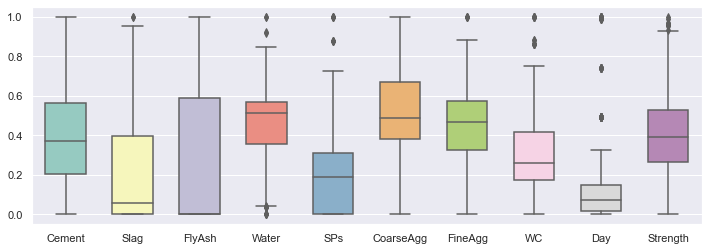

In [7]:
#dfNorm = df.iloc[:,:-1]
dfNorm = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)
#dfNorm['Strength'] = df['Strength']
plt.figure(figsize=(12,4))
sns.boxplot(data = dfNorm, palette='Set3', width =0.6)
plt.show()

- Veri seti normalize edilip, aykırı değerler incelendi.
- Çok yoğun olmamakla beraber, Day ve Water sütunlarında daha fazla aykırı değer gözlemlenmektedir.

In [8]:
def dfWinsorize(df):
    dfWin = df.copy()
    for col in dfWin.columns[:-1]:
        if (dfi.loc[col, 'upout_'] != 0) | (dfi.loc[col, 'lowout_'] != 0):
            dfWin[col] = winsorize(dfWin[col], ((dfi.loc[col, 'lowout_'] / 100) + 1e-5, 
                                          (dfi.loc[col, 'upout_'] / 100) + 1e-5)) #alt-üst
    return dfWin
dfWin = dfWinsorize(df)

- Strenght hariç diğer sütunlar winsorize edildi.
- Veri kaybını en aza indirgemek için, alt-üst limiti olarak aykırı değer sınırları tercih edildi.

#### 3.2. Dağılımlar

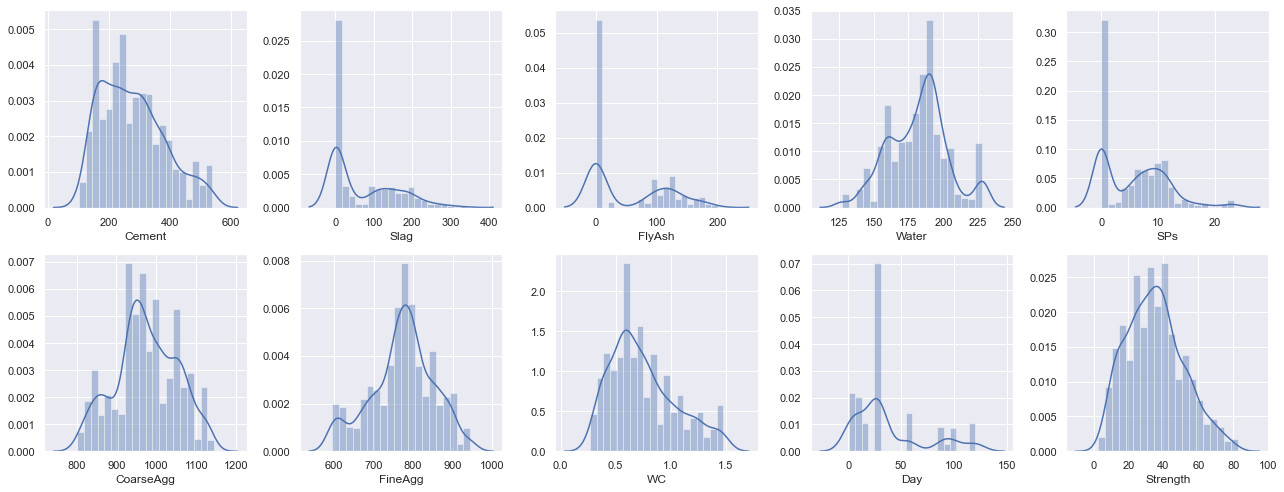

In [9]:
plt.figure(figsize=(18,7))
for num,col in enumerate(df.columns,1):
    plt.subplot(2, 5, num)
    sns.distplot(dfWin[col], bins=20)
    plt.tight_layout()

<Figure size 1296x504 with 0 Axes>

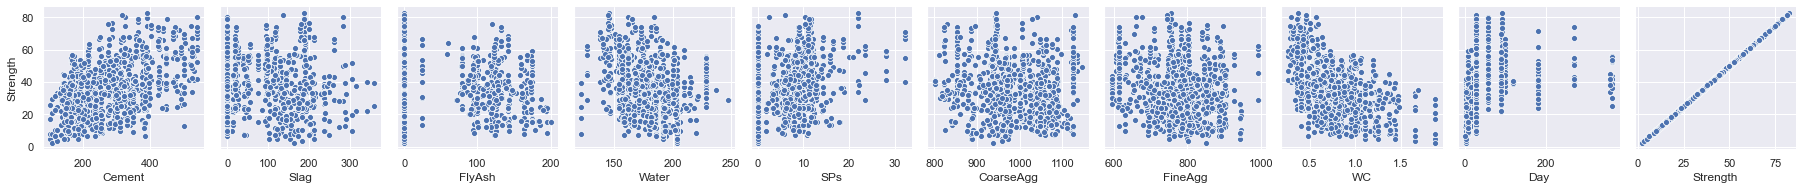

In [10]:
plt.figure(figsize=(18,7))
sns.pairplot(data=df, y_vars = ["Strength"], x_vars = df.columns)
plt.show()

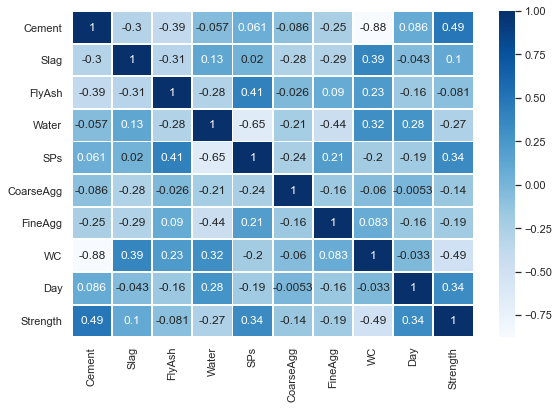

In [11]:
plt.figure(figsize=(9,6))
sns.heatmap(df.corr(), annot=True, linewidths=0.9, cmap='Blues')
plt.show()

- Strength ve Cement arasında yüksek pozitif korelasyon bulunmaktadır.
- W/C oranını düşük tutabilmek için, yoğun olarak SPs kullanılmaktadır; Strenght ve SPs arasındaki yüksek kolerasyonun sebebi bu olabilir.
- Yüksek dayanımlı beton elde etmek için W/C oranı düşük tutulmaya çalışılır.
- Güne bağlı olarak beton mukavement kazanmaktadır.
- Su ihtiyacını azatmak için SPs kullanımaktadır.
- Agrega boyutuna göre SPs arasında yoğun ilişki gözlemleniyor.

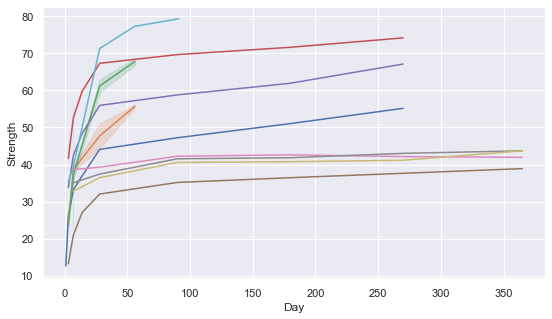

In [12]:
def dayStrength(df):
    dfCopy = df.copy()
    plt.figure(figsize=(9,5))
    dfCopy['Count'] = dfCopy.groupby(['Cement', 'Slag', 'FlyAsh', 'Water' , 'SPs' , 'CoarseAgg', 'FineAgg', 'WC'])['Day'].transform('count')
    dfDay = dfCopy.sort_values(by=['Count','Cement','Day'],ascending=[False,False,True])
    groupDay = [dfDay[0:8],dfDay[8:16],dfDay[16:24],dfDay[24:31],dfDay[31:38],dfDay[38:45],dfDay[45:51],dfDay[51:57],dfDay[57:63],dfDay[63:69]]
    for day in groupDay:
        sns.lineplot(x=day.Day, y=day.Strength)
    return plt.show()
dayStrength(df)

- Her bir grafik için betonun bileşenleri sabit tutulup, gün bazlı dayanımın değişimi incelenmiştir.
- Beton 28. güne kadar hızla dayanım kazanmaktadır. 
- 28 gün sonrasıda dahi dayanım kazanmaya devam etmektedir. Ama daha yavaş olmaktadır.
- Beton dayanımın yaklaşık %95'ini 28 günde kazanmaktadır.
- Bu grafik beton dayanım deneylerinin 28. gün ile açıklanması için iyi bir örnektir.

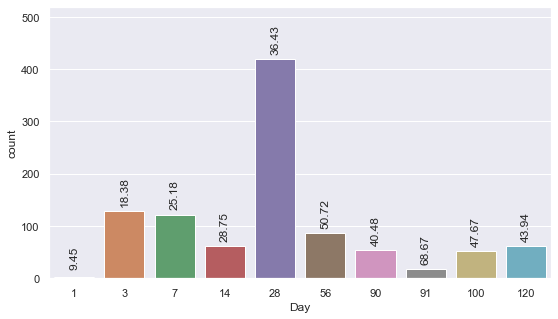

In [13]:
dfCopy = dfWin.copy()
plt.figure(figsize=(9,5))
ax = sns.countplot(x='Day', data = dfCopy)
plt.ylim(0, 520)
for i, p in enumerate(ax.patches):
    ax.annotate("%.2f" % list(dfCopy.groupby(['Day'])['Strength'].mean())[i], (p.get_x() + p.get_width() / 2, p.get_height()),
                     ha='center', va='center', rotation=90, xytext=(0, 20), textcoords='offset points')

- Grafik, verinin günlere göre dağılımını göstermektedir, üzerindeki sayı ise ortalama dayanımını ifade etmektedir.
- Güne bağlı dayanım grafikleri incelendiğinde 28 güne kadar hızla dayanım kazanırken, bu artış 90 günün artından yavaşlıyor.
- Day sütununu küçültmek için 90+ değerler, 90 ile değiştirildi; 1 olanlar ile 3 olarak değiştirildi.

In [26]:
def day90(dfCopy):
    dfCopy.at[dfCopy.Day == 1, 'Day'] = 3
    dfCopy.at[dfCopy.Day == 91, 'Day'] = 90
    dfCopy.at[dfCopy.Day == 100, 'Day'] = 90
    dfCopy.at[dfCopy.Day == 120, 'Day'] = 90
    dfCopy.at[dfCopy.Day == 180, 'Day'] = 90
    dfCopy.at[dfCopy.Day == 270, 'Day'] = 90
    dfCopy.at[dfCopy.Day == 360, 'Day'] = 90
    dfCopy.at[dfCopy.Day == 365, 'Day'] = 90
    return dfCopy
dfWin = day90(dfWin)

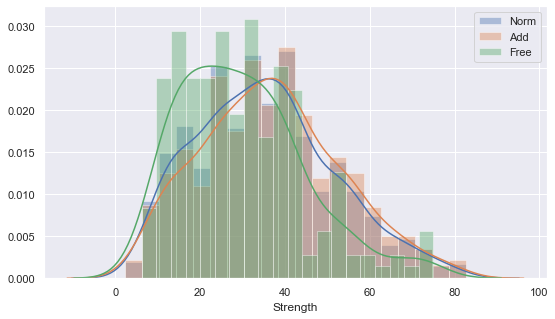

In [16]:
def dfAdditive(df):
    dfCopy = df.copy()
    plt.figure(figsize=(9,5))
    dfFree = dfCopy[(dfCopy.Slag == 0) & (dfCopy.FlyAsh == 0) & (dfCopy.SPs == 0)][['Cement','Water','CoarseAgg','FineAgg','WC','Day','Strength']]
    dfAdd = dfCopy[(dfCopy.Slag != 0) | (dfCopy.FlyAsh != 0) | (dfCopy.SPs != 0)]
    sns.distplot(dfCopy['Strength'], bins=20, label='Norm')
    sns.distplot(dfAdd['Strength'], bins=20, label='Add')
    sns.distplot(dfFree['Strength'], bins=20, label='Free')
    plt.legend()
    return plt.show()
dfAdditive(dfWin)

In [17]:
def dfAdd(dfCopy):  
    dfCopy['Additive'] = 0
    dfCopy.at[(dfCopy.Slag == 0) & (dfCopy.FlyAsh == 0) & (dfCopy.SPs == 0), 'Additive'] = 0
    dfCopy.at[(dfCopy.Slag != 0) | (dfCopy.FlyAsh != 0) | (dfCopy.SPs != 0), 'Additive'] = 1
    return dfCopy
dfWin = dfAdd(dfWin)

- Grafik, beton dayanımının katkı maddelerinin kullanımı ile değişimini göstermektedir.
- Katkı maddeleri kullanılmayan beton daha zayıf bir dayanım göstermektedir.
- Katkılı beton sola çarpık bir eğilim göstermektedir.
- Katkı maddesinin hiç kullanılmadığı (0) ve en az bir katkı maddesi kullanılan (1) değerlerinin bulunduğu yeni bir sütun oluşturuldu.

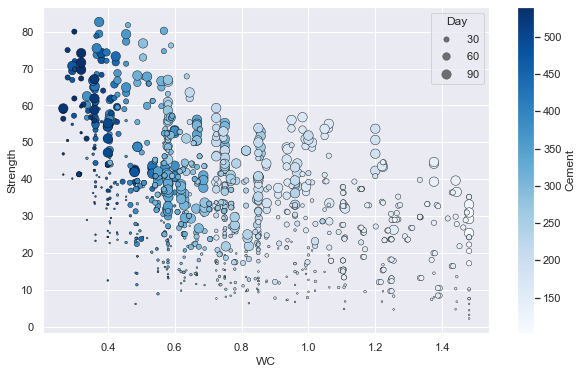

In [18]:
plt.figure(figsize=(10,6))
ax = plt.scatter(dfWin['WC'], dfWin['Strength'], c=dfWin['Cement'], s=dfWin['Day'], linewidth=0.4, edgecolor="black", cmap="Blues")
plt.legend(*ax.legend_elements(prop='sizes', alpha=0.6, num=3), title='Day')
plt.colorbar(label='Cement')
plt.xlabel('WC')
plt.ylabel('Strength')
plt.show()

- Grafik W/C, çimento ve gün değişkenlerine bağıl olarak dayanımın değişimini göstermektedir.
- Yüksek dayanımlı beton üretebilmek için W/C oranının olabildiğince düşük olmalıdır.
- Çimento kullanımının artması, dayanımı pozitif yönde etkilemektedir.
- Suyun çimentoya göre daha fazla kullanılması dayanımı düşürmektedir.
- Betonun bekleme süresi, çimento oranı yüksek ise dayanımı artırmaktadır.

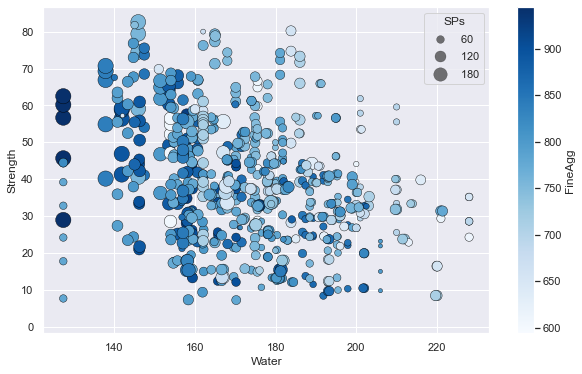

In [19]:
plt.figure(figsize=(10,6))
ax = plt.scatter(dfWin['Water'], dfWin['Strength'], c=dfWin['FineAgg'], s=dfWin['SPs']*10, linewidth=0.4, edgecolor="black", cmap="Blues")
plt.legend(*ax.legend_elements(prop='sizes', alpha=0.6, num=4), title='SPs')
plt.colorbar(label='FineAgg')
plt.xlabel('Water')
plt.ylabel('Strength')
plt.show()

- Grafik su, kum ve akışkanlaştırıcı değişkenlerine bağıl olarak dayanımın değişimini göstermektedir.
- Beton suyun artmasıyla dayanım kaybetmektedir.
- Betonda su kullanımını azaltmak için SPs kullanılmaktadır.
- Kum ve SPs ikilisi beraber kullanımda su kullanımını minimize etmektedir.

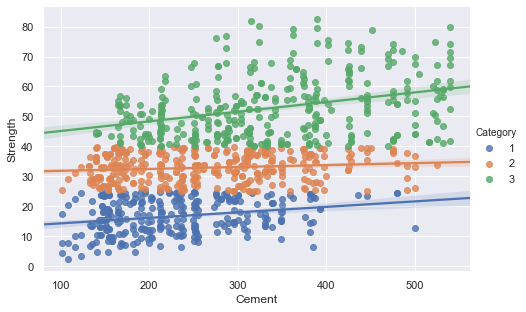

In [20]:
def catStrength(df):
    if df.Strength < 25:
        return '1'
    if df.Strength > 25 and df.Strength < 40:
        return '2'
    if df.Strength > 40:
        return '3'
dfWin["Category"] = dfWin.apply(lambda dfWin:catStrength(dfWin), axis =1).astype(int)
sns.lmplot(x='Cement', y='Strength', data = dfWin, hue = 'Category', truncate = False, height=4.5, aspect=1.5)
plt.show()

- Betonun dayanım sınıfına göre yeni sütun eklendi.
- Hafif beton < 25 < normal beton < 40 < yüksek dayanımlı beton olarak tercih edilmiştir.
- Modelden daha anlamlı sonuç alabilmek için oluşturuldu.

### 4. Model

In [42]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from scipy.stats import bartlett, levene, jarque_bera, normaltest
from statsmodels.tsa.stattools import acf
from yellowbrick.regressor import AlphaSelection
sns.set()

In [43]:
cc = dfWin.copy()
#cc = StandardScaler().fit_transform(cc)
#cc = pd.DataFrame(cc, columns=dfWin.columns)

In [44]:
Y = cc['Strength']
X = cc[['Cement', 'Slag', 'FlyAsh', 'Water', 'SPs', 'CoarseAgg', 'FineAgg', 'WC', 'Day', 'Additive']]

In [45]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [46]:
#model = LinearRegression().fit(x_train, y_train)
#y_pred = model.predict(x_test)
standardscaler = StandardScaler()
x_train = standardscaler.fit_transform(x_train)
x_test = standardscaler.transform(x_test)
x_train = pd.DataFrame(x_train, columns=X.columns)
x_test = pd.DataFrame(x_test, columns=X.columns)

In [47]:
model = LinearRegression().fit(x_train, y_train)
y_pred = model.predict(x_test)

#### Varsayım 1
Modelin katsayıları ve hedefi lineer olmalıdır.

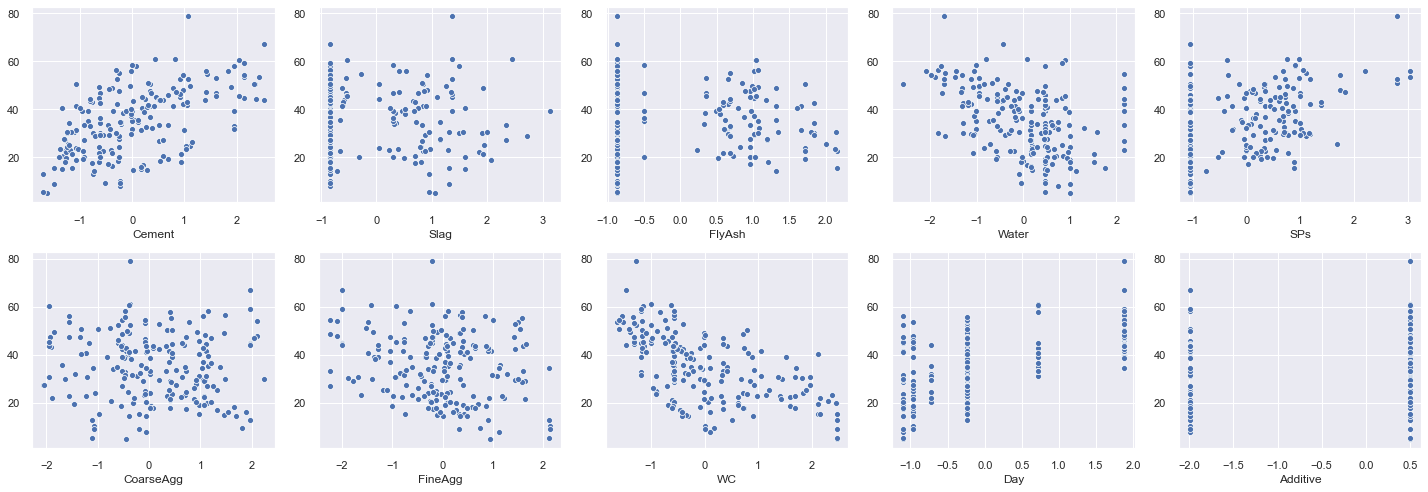

In [48]:
feat = ['Cement', 'Slag', 'FlyAsh', 'Water', 'SPs', 'CoarseAgg', 'FineAgg', 'WC', 'Day', 'Additive']
plt.figure(figsize=(20,7))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.scatterplot(x= x_test[feat[i]] , y = y_pred)
    plt.ylabel('')
    plt.xlabel(feat[i])
    plt.tight_layout()

#### Varsayım 2
Hata terimlerinin ortalaması 0 olmalıdır.

In [49]:
errors = y_test - y_pred
print("Ortalama Hata: {:.10f}".format(np.mean(errors)))

Ortalama Hata: 1.0289996966


#### Varsayım 3
Modelin homoscedasticity davranış sergilemesi beklenir.
Grafikten varyansın büyüdüğü görülüyor ve p-değerleri 0.05'den kücüktür; homoscedasticity davranış sergilemektedir.

Bartlett Değeri: 36.3821 ve p değeri : 0.000000001621866
Levene Değeri  : 47.3597 ve p değeri : 0.000000000022919


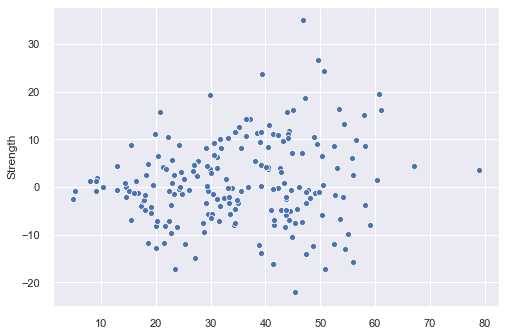

In [50]:
bart_stats = bartlett(y_pred, errors)
lev_stats = levene(y_pred, errors)
print("Bartlett Değeri: {0:3g} ve p değeri : {1:.15f}".format(bart_stats[0], bart_stats[1]))
print("Levene Değeri  : {0:3g} ve p değeri : {1:.15f}".format(lev_stats[0], lev_stats[1]))
sns.scatterplot(x=y_pred, y=errors)
plt.show()

#### Varsayım 4
Özelliklerin birbiriyle zayıf ilişkisi (low multicollinearity) olmalıdır.

In [51]:
x_train.corr()

,Cement,Slag,FlyAsh,Water,SPs,CoarseAgg,FineAgg,WC,Day,Additive
Cement,1.000,-0.290,-0.399,-0.027,0.035,-0.094,-0.246,-0.893,0.056,-0.369
Slag,-0.290,1.000,-0.319,0.125,0.014,-0.279,-0.301,0.379,-0.026,0.421
FlyAsh,-0.399,-0.319,1.000,-0.299,0.442,-0.019,0.113,0.268,-0.073,0.440
Water,-0.027,0.125,-0.299,1.000,-0.654,-0.201,-0.468,0.289,0.145,-0.244
SPs,0.035,0.014,0.442,-0.654,1.000,-0.256,0.223,-0.173,-0.068,0.530
CoarseAgg,-0.094,-0.279,-0.019,-0.201,-0.256,1.000,-0.159,-0.037,-0.021,-0.312
FineAgg,-0.246,-0.301,0.113,-0.468,0.223,-0.159,1.000,0.062,-0.084,0.014
WC,-0.893,0.379,0.268,0.289,-0.173,-0.037,0.062,1.000,-0.030,0.306
Day,0.056,-0.026,-0.073,0.145,-0.068,-0.021,-0.084,-0.030,1.000,-0.029
Additive,-0.369,0.421,0.440,-0.244,0.530,-0.312,0.014,0.306,-0.029,1.000


#### Varsayım 5
Hata terimleri birbiriyle ilişkisiz olmalıdır.
Otokorelasyon grafiğine göre ilişki seviyesi düşüktür.

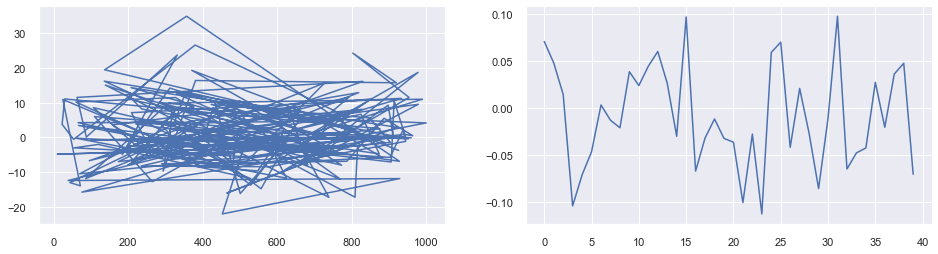

In [52]:
plt.figure(figsize=(16,4))
plt.subplot(1, 2, 1)
plt.plot(errors)
plt.subplot(1, 2, 2)
plt.plot(acf(errors,fft=True)[1:])
plt.show()

#### Varsayım 6
Özellikler hatalarla ilişkili olmamalıdır.

In [53]:
cc['Errors'] = errors
exogeneity = cc[['Cement', 'Slag', 'FlyAsh', 'Water', 'SPs', 'CoarseAgg', 'FineAgg', 'WC', 'Day', 'Additive', 'Errors']]
exogeneity.corr().Errors

Cement       0.038
Slag         0.111
FlyAsh      -0.078
Water       -0.048
SPs         -0.007
CoarseAgg    0.003
FineAgg     -0.048
WC          -0.044
Day          0.084
Additive     0.063
Errors       1.000
Name: Errors, dtype: float64

#### Hataların Normalliği
Hata terimleri normal olarak dağıtılmalıdır. Modelin hatalarının normal(lineer grafik, çan eğrisi, p-değeri = 0) dağıldığı görülmektedir.

Jarque-Bera test değeri : 11.282848 ve p değeri : 0.003547811841503
Normal test değeri      : 10.253631 ve p değeri : 0.005935432094307


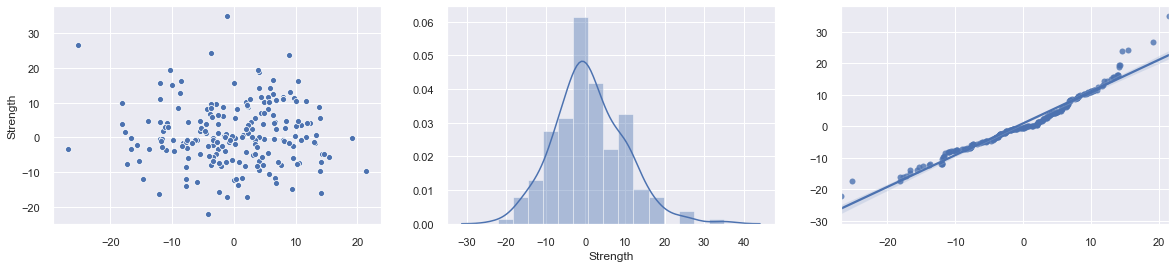

In [54]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)
print("Jarque-Bera test değeri : {0:.6f} ve p değeri : {1:.15f}".format(jb_stats[0], jb_stats[1]))
print("Normal test değeri      : {0:.6f} ve p değeri : {1:.15f}".format(norm_stats[0], norm_stats[1]))

randomNumber = np.random.normal(np.mean(errors), np.std(errors), len(errors))
plt.figure(figsize=(20,4))
plt.subplot(1, 3, 1)
sns.scatterplot(x=randomNumber, y=errors)
plt.subplot(1, 3, 2)
sns.distplot(errors)
plt.subplot(1, 3, 3)
sns.regplot(np.sort(randomNumber), np.sort(errors))
plt.show()

In [55]:
Y1 = cc['Strength']
X1 = [cc[['Cement', 'Slag', 'FlyAsh', 'Water', 'SPs', 'CoarseAgg', 'FineAgg', 'WC', 'Day', 'Additive']],  #model1      
      cc[['Cement', 'Slag', 'FlyAsh', 'Water', 'SPs', 'CoarseAgg', 'FineAgg', 'WC', 'Day']],  #model2
      cc[['Cement', 'Slag', 'FlyAsh', 'SPs', 'CoarseAgg', 'FineAgg', 'WC', 'Day', 'Additive']],  #model3
      cc[['Cement', 'Slag', 'FlyAsh', 'Water', 'SPs', 'CoarseAgg', 'FineAgg', 'Day' ]],  #model4
      cc[['Cement', 'Slag', 'FlyAsh', 'SPs', 'CoarseAgg', 'FineAgg', 'WC', 'Day']], #model5
      cc[['Cement', 'Slag', 'FlyAsh', 'SPs', 'CoarseAgg', 'FineAgg', 'Day']]]  #model6

In [56]:
def perfstats(col, Y):
    pf = pd.DataFrame(columns=['model', 'rsq', 'rsq_adj', 'f_value', 'aic', 'bic', 'mae', 'mse', 'rmse', 'mape'])
    pd.options.display.float_format = '{:.3f}'.format
    for num,X in enumerate(col,1): 
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
        
        standardscaler = StandardScaler()
        x_train = standardscaler.fit_transform(x_train)
        x_test = standardscaler.transform(x_test)
        
        x_train = sm.add_constant(x_train)
        results = sm.OLS(y_train, x_train).fit()
        x_test = sm.add_constant(x_test)
        y_pred = results.predict(x_test)
        pf.loc[num] = ('model_'+str(num) , results.rsquared, results.rsquared_adj, results.fvalue, results.aic, results.bic, 
                       mean_absolute_error(y_test, y_pred), mse(y_test, y_pred), rmse(y_test, y_pred), (np.mean(np.abs((y_test - y_pred) / y_test)) * 100))
    return pf

In [57]:
def predplts(col, Y, Alpha, size, regType):
    if(len(col) % 3) == 0:
        row = int(len(col) / 3)
    elif (len(col) % 3) != 0:
        row = int((len(col) // 3) +1)
    for num,X in enumerate(col,1): 
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = size, random_state = 42)
        
        standardscaler = StandardScaler()
        x_train = standardscaler.fit_transform(x_train)
        x_test = standardscaler.transform(x_test)
        
        if str(regType) == 'linear':
            results = LinearRegression().fit(x_train, y_train)
        elif str(regType) == 'ridge':
            results = Ridge(alpha=Alpha).fit(x_train, y_train)
        elif str(regType) == 'lasso':
            results = Lasso(alpha=Alpha).fit(x_train, y_train)
        elif str(regType) == 'elasticnet':
            results = ElasticNet(alpha=Alpha, l1_ratio=0.2).fit(x_train, y_train)

        y_pred = results.predict(x_test)
        
        plt.subplot(row, 3, num)
        sns.scatterplot(x=y_test, y=y_pred)
        sns.lineplot(x=y_test, y=y_test, color='salmon', label='ytest')
        plt.ylabel("predict")
        plt.title('model_'+str(num))
        plt.tight_layout()
    return 

In [58]:
def regstats(col, Y, perc, Alpha, regType):  #'linear', 'ridge', 'lasso', 'elasticnet'
    
    pf = pd.DataFrame(columns=['model', 'rsq_train', 'rsq_test', 'subt_rsq', 'mae_test', 'mse_test', 'rmse_test', 'mape_test']) 
    pd.options.display.float_format = '{:.3f}'.format
    
    
    for num,X in enumerate(col,1): 
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = perc, random_state = 54)
        
        standardscaler = StandardScaler()
        x_train = standardscaler.fit_transform(x_train)
        x_test = standardscaler.transform(x_test)
        
        
        if str(regType) == 'linear':
            results = LinearRegression().fit(x_train, y_train)
        elif str(regType) == 'ridge':
            results = Ridge(alpha=Alpha).fit(x_train, y_train)
        elif str(regType) == 'lasso':
            results = Lasso(alpha=Alpha).fit(x_train, y_train)
        elif str(regType) == 'elasticnet':
            results = ElasticNet(alpha=Alpha, l1_ratio=0.2).fit(x_train, y_train)

        y_pred = results.predict(x_test)
        
        pf.loc[num] = (str(num)+'_'+regType,
                       results.score(x_train, y_train),
                       results.score(x_test, y_test),
                       results.score(x_train, y_train) - results.score(x_test, y_test),
                       mean_absolute_error(y_test, y_pred), 
                       mse(y_test, y_pred), 
                       rmse(y_test, y_pred), 
                       (np.mean(np.abs((y_test - y_pred) / y_test)) * 100))
    return pf

In [59]:
def coefplts(X2,Y2):
    x_train, x_test, y_train, y_test = train_test_split(X2, Y2, test_size = 0.2, random_state = 42)
    
    standardscaler = StandardScaler()
    x_train = standardscaler.fit_transform(x_train)
    x_test = standardscaler.transform(x_test)
    
    model1 = LinearRegression().fit(x_train, y_train)
    model2 = Ridge(alpha=1).fit(x_train, y_train)
    model3 = Lasso(alpha=.01).fit(x_train, y_train)
    model4 = ElasticNet(alpha=0.01, l1_ratio=0.5).fit(x_train, y_train)
    dfCoef = pd.DataFrame([model1.coef_[0:],model2.coef_[0:],model3.coef_[0:],model4.coef_[0:]], columns=X2.columns, index=['Linear','Ridge','Lasso','Elasticnet']).T
    
    ax =dfCoef.plot.bar(rot=0, figsize=(15, 4), width=0.9)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    for i, p in enumerate(ax.patches):
        ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()),
                         ha='center', va='center', rotation=90, xytext=(0, 20), textcoords='offset points')
    plt.ylim(-4, 14)
    plt.tight_layout()
    plt.show()
    return 


### 4.1. Ordinary Least Squares

In [60]:
perfstats(X1, Y1)  #OLS

,model,rsq,rsq_adj,f_value,aic,bic,mae,mse,rmse,mape
1,model_1,0.762,0.759,254.533,5607.602,5659.187,6.788,79.264,8.903,23.552
2,model_2,0.759,0.756,277.464,5618.052,5664.948,6.888,81.479,9.027,23.673
3,model_3,0.758,0.755,275.715,5621.906,5668.802,6.870,81.910,9.050,23.666
4,model_4,0.756,0.753,307.574,5625.805,5668.012,6.909,82.508,9.083,24.276
5,model_5,0.755,0.752,305.713,5629.489,5671.696,6.926,83.632,9.145,23.806
6,model_6,0.749,0.747,339.996,5644.723,5682.240,6.991,85.575,9.251,24.637


### 4.2. Linear Regression

In [61]:
regstats(X1, Y1, 0.2, 0, 'linear')  #'linear', 'ridge', 'lasso', 'elasticnet'

,model,rsq_train,rsq_test,subt_rsq,mae_test,mse_test,rmse_test,mape_test
1,1_linear,0.754,0.765,-0.011,6.110,64.629,8.039,22.233
2,2_linear,0.748,0.765,-0.017,6.049,64.533,8.033,21.612
3,3_linear,0.747,0.762,-0.015,6.104,65.355,8.084,22.092
4,4_linear,0.744,0.770,-0.026,6.074,63.259,7.954,22.211
5,5_linear,0.743,0.762,-0.019,6.016,65.455,8.090,21.425
6,6_linear,0.735,0.769,-0.034,6.021,63.542,7.971,22.053


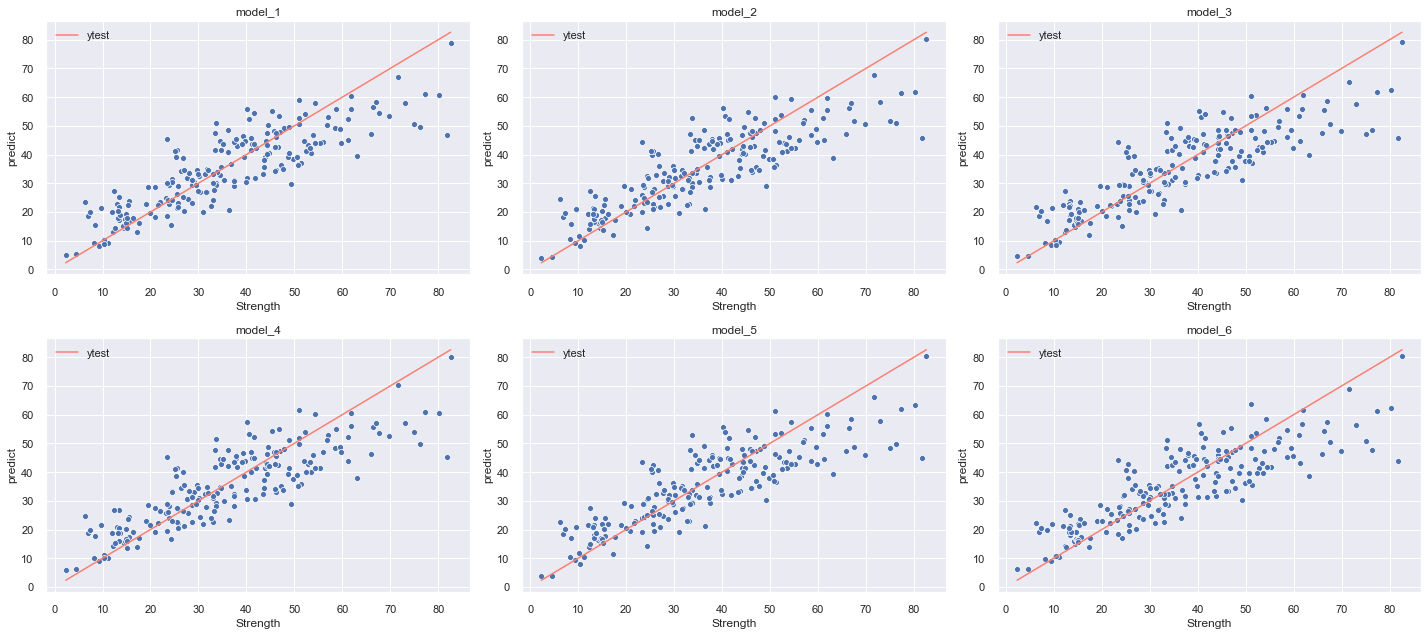

In [62]:
plt.figure(figsize=(20,9))
predplts(X1, Y1, 1, 0.2, 'linear')

### 4.3. Ridge Regression

In [63]:
regstats(X1, Y1, 0.2, 1, 'ridge')  #'linear', 'ridge', 'lasso', 'elasticnet'

,model,rsq_train,rsq_test,subt_rsq,mae_test,mse_test,rmse_test,mape_test
1,1_ridge,0.754,0.764,-0.010,6.117,64.727,8.045,22.259
2,2_ridge,0.748,0.765,-0.016,6.056,64.633,8.039,21.650
3,3_ridge,0.747,0.762,-0.014,6.109,65.484,8.092,22.117
4,4_ridge,0.744,0.769,-0.026,6.080,63.347,7.959,22.256
5,5_ridge,0.743,0.761,-0.018,6.024,65.583,8.098,21.466
6,6_ridge,0.735,0.768,-0.034,6.025,63.616,7.976,22.102


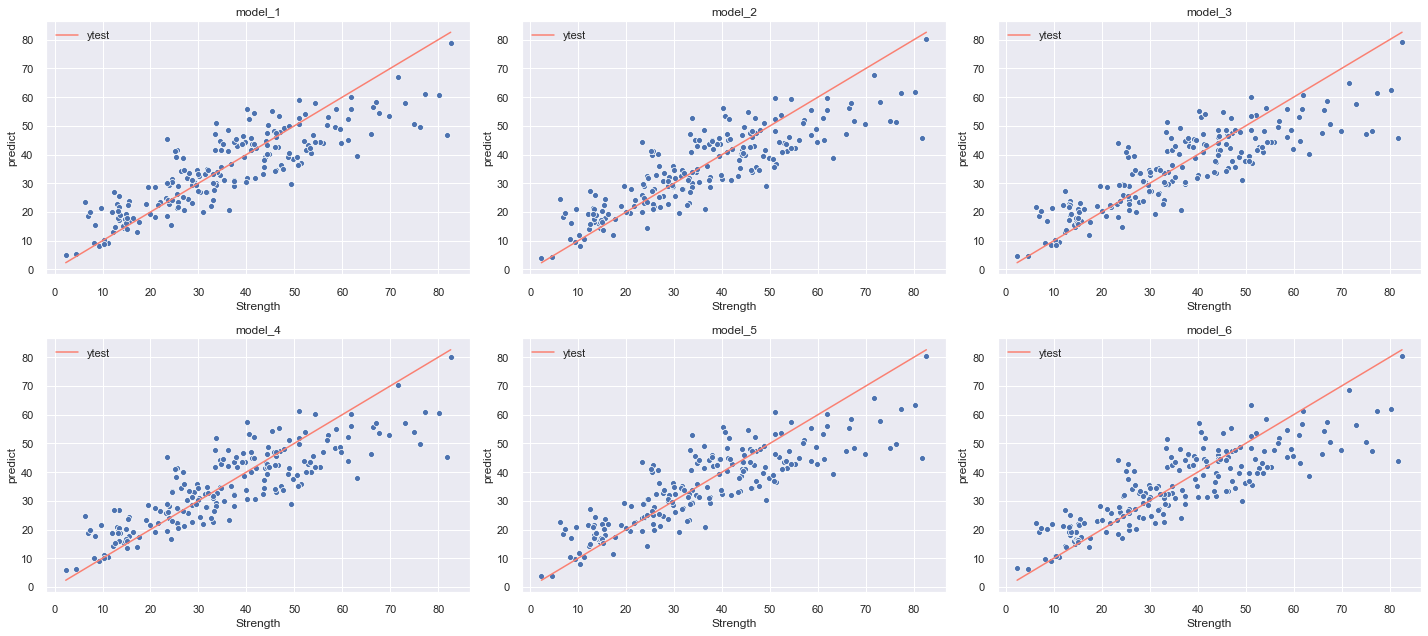

In [64]:
plt.figure(figsize=(20,9))
predplts(X1, Y1, 1, 0.2, 'ridge')

### 4.4. Lasso Regression

In [65]:
regstats(X1, Y1, 0.2, 1, 'lasso')  #'linear', 'ridge', 'lasso', 'elasticnet'

,model,rsq_train,rsq_test,subt_rsq,mae_test,mse_test,rmse_test,mape_test
1,1_lasso,0.719,0.732,-0.013,6.622,73.738,8.587,26.723
2,2_lasso,0.703,0.724,-0.021,6.723,75.852,8.709,26.739
3,3_lasso,0.701,0.716,-0.015,6.822,78.028,8.833,27.031
4,4_lasso,0.699,0.728,-0.029,6.716,74.677,8.642,27.522
5,5_lasso,0.689,0.710,-0.021,6.867,79.764,8.931,26.968
6,6_lasso,0.669,0.705,-0.036,6.937,81.058,9.003,28.657


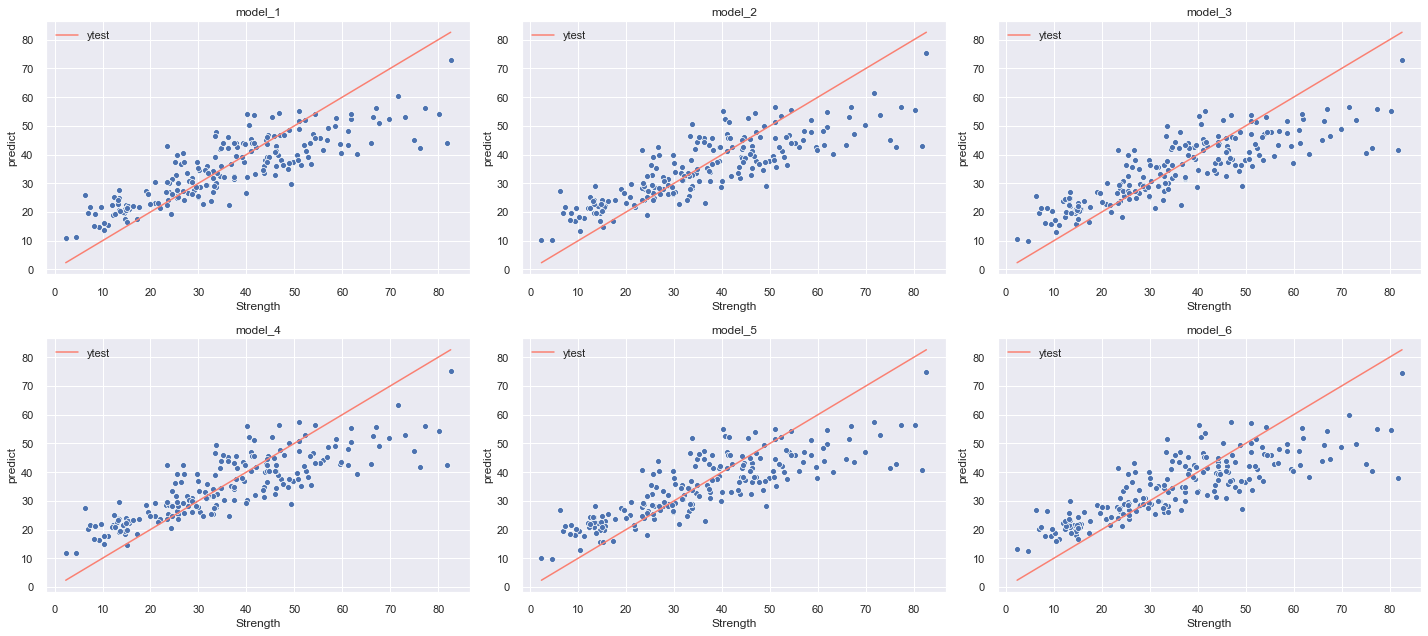

In [66]:
plt.figure(figsize=(20,9))
predplts(X1, Y1, 1, 0.2, 'lasso')

### 4.5. Elasticnet Regression

In [67]:
regstats(X1, Y1, 0.2, .01, 'elasticnet')  #'linear', 'ridge', 'lasso', 'elasticnet'

,model,rsq_train,rsq_test,subt_rsq,mae_test,mse_test,rmse_test,mape_test
1,1_elasticnet,0.754,0.763,-0.009,6.144,65.209,8.075,22.384
2,2_elasticnet,0.748,0.763,-0.015,6.095,65.141,8.071,21.857
3,3_elasticnet,0.747,0.759,-0.012,6.148,66.185,8.135,22.309
4,4_elasticnet,0.743,0.768,-0.025,6.110,63.814,7.988,22.493
5,5_elasticnet,0.743,0.759,-0.016,6.072,66.287,8.142,21.712
6,6_elasticnet,0.734,0.767,-0.033,6.055,64.129,8.008,22.389


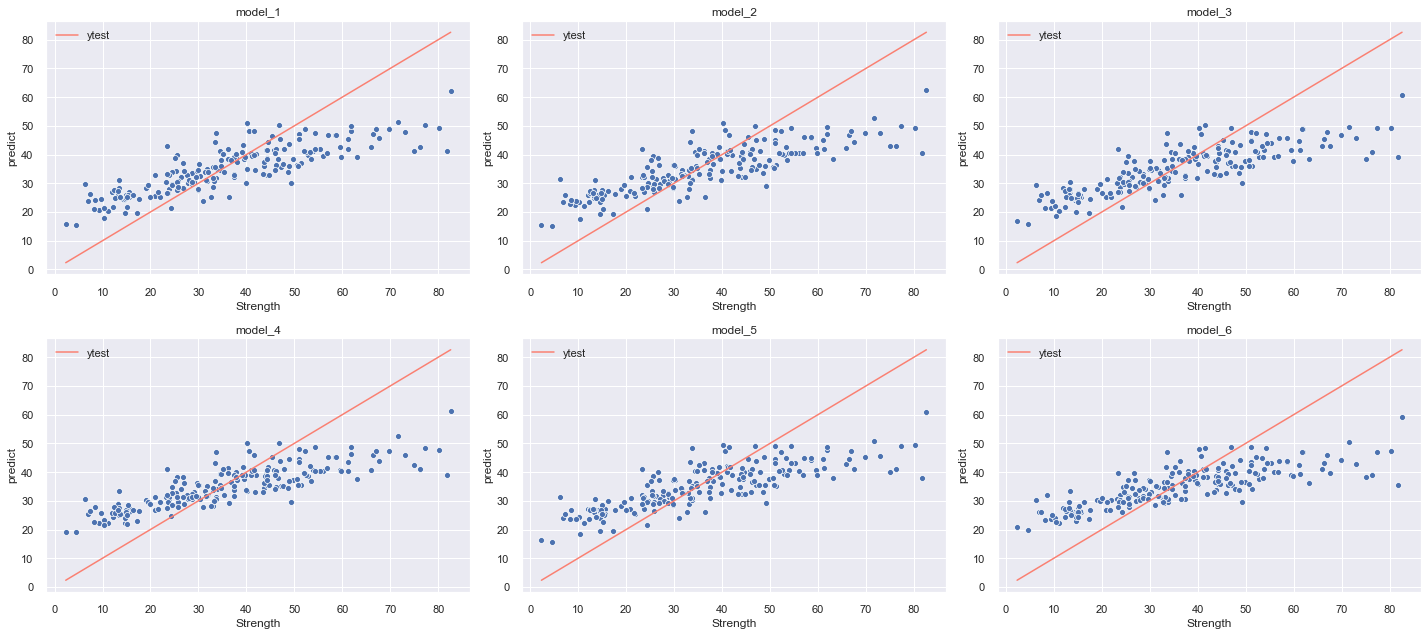

In [68]:
plt.figure(figsize=(20,9))
predplts(X1, Y1, 1, 0.2, 'elasticnet')

- En iyi sonucular model_1'den alındı.
- WC üzerinde Water değerlerini kullandığımız için Water sütununu kaldırıldı.

### 4.6. Katsayıların Karşılaştırılması

In [69]:
Y2 = cc['Strength']
X2 = cc[['Cement', 'Slag', 'FlyAsh', 'SPs', 'CoarseAgg', 'FineAgg', 'WC', 'Day', 'Additive']]

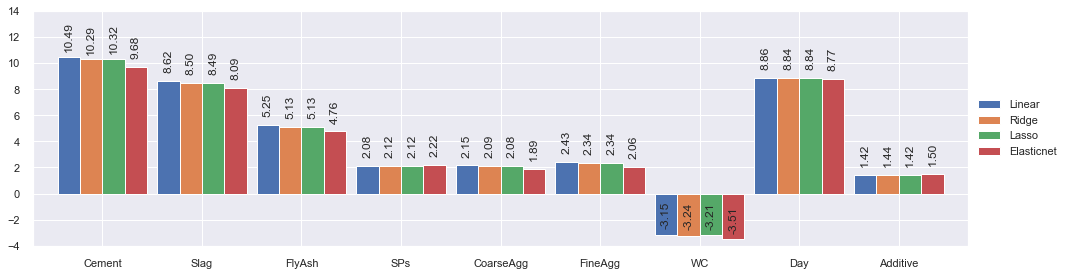

In [70]:
coefplts(X2,Y2)

### 5. Sonuç

İncelediğimiz Basınç Dayanım Verileri'nden iyi bir tahmin alabilmek için alternatif modeller kullanıldı. En iyi tahmini alabilmek için 4 alternatif regresyon yöntemi üzerinde 6 farklı özellikte modeller denendi. Bu modeller arasında en iyi sonuca 2 nolu model üzeride, Ridge yöntemiyle ulaşıldı. Ayrıca hiperparametreler üzerinde ayarlama yapılabilirse daha iyi sonuçlar alınabilir. En uygun model üzerinde katsayılar incelendiğinde, beton dayanımı için çimento en yüksek değere sahip, ardından cüruf ve gün etkenleri geliyor. Su değişkeni yerine kullanmayı tercih ettiğimiz Su/Çimento değişkeni ise negatif olarak etkimektedir.